### Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import random
import collections

### Configurations

In [2]:
M           = 8                 # Number of clients
A           = 10                # Local epochs
G           = 100               # Global rounds
bs          = 64                # Batch size
lr          = 0.01              # Learning rate
clip_C      = 1.0               # Clipping norm
delta       = 1e-5              # DP Parameter δ
eps_list    = [1, 2, 5, 10]     # Privacy budgets ε

device      = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cs = 1.0  # Sensing rate: samples/sec (for dataset growth plot)

### Wireless / OFDMA parameters

In [3]:
K       = 16              # Subcarriers
BW      = 80e6            # Total bandwidth (Hz)
sigma2  = 10**(-169/10)   # Noise power density (W/Hz)
Pmax    = 10**(-30/10)    # 10 dBm in Watts
rs      = [2,4,6]         # bits per symbol
beta1, beta2 = 0.2, -1.6  # BER constants
d0, alpha = 1.0, 2.5      # path-loss reference & exponent
Tsc     = 10.0            # ISAC slot duration (sec)
a_m     = 0.5             # fraction for sensing/training

### Model Definition

In [4]:
class SimpleMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 32)
        self.fc2 = nn.Linear(32, 10)
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

### IID Split

In [5]:
def get_iid_loaders(dataset, M, bs):
    idx = torch.randperm(len(dataset))
    split = len(dataset) // M
    loaders = []
    for i in range(M):
        part = idx[i*split:(i+1)*split]
        loaders.append(DataLoader(Subset(dataset, part), batch_size=bs, shuffle=True))
    return loaders

### Wireless helper: generate SISO Rayleigh channels

In [6]:
def gen_channels(positions):
    H = np.zeros((M,K), dtype=complex)
    for m,(x,y) in enumerate(positions):
        d = np.hypot(x,y) + 1e-6
        pl = 10**(-30/10)*(d/d0)**(-alpha)
        # Rayleigh: CN(0,pl)
        h = np.sqrt(pl)*(np.random.randn(K)+1j*np.random.randn(K))/np.sqrt(2)
        H[m] = h
    return H

### Pick one subcarrier & modulation, compute R and upload time

In [7]:
def compute_uplink(Hm, N_bits, a_m=a_m):
    best = (0,None,0,0)
    Tmax = (1 - a_m)*Tsc
    sym_rate = BW/K
    for k in range(K):
        gain2 = abs(Hm[k])**2
        for r in rs:
            # required SNR threshold from BER <= 1e-5
            SNR_th = (2*r-1)/(-beta2)*np.log(beta1/1e-5)
            p_req = SNR_th * sigma2 / gain2
            if p_req <= Pmax:
                R = r * sym_rate
                Tu = N_bits / R
                if Tu <= Tmax and R>best[0]:
                    best = (R,k,r,Tu)
    return best  # (rate, subcarrier, bits/symbol, upload_time) or (0,None,0,0)

### DP Clip & Noise

In [8]:
def dp_clip_and_noise(client_model, global_model, eps, delta, clip_C, G, Dmin):
    sensitivity = 2*clip_C / Dmin
    sigma = (sensitivity * np.sqrt(2*G*np.log(1.25/delta))) / eps
    g_state = global_model.state_dict()
    c_state = client_model.state_dict()
    new_state = {}
    for k in g_state:
        dw = c_state[k].to(device) - g_state[k].to(device)
        norm = torch.norm(dw)
        if norm > clip_C:
            dw = dw * (clip_C/norm)
        noise = torch.randn_like(dw)*sigma
        new_state[k] = g_state[k].to(device) + dw + noise
    return new_state

### Server aggregation

In [9]:
def server_aggregate(states):
    agg = {}
    for k in states[0]:
        agg[k] = sum([st[k] for st in states]) / len(states)
    return agg

### Train & Eval

In [10]:
def local_train(model, loader, global_state):
    model.load_state_dict(global_state)
    opt = optim.SGD(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    model.train()
    for _ in range(A):
        for x,y in loader:
            x,y = x.to(device), y.to(device)
            opt.zero_grad()
            logits = model(x)
            loss_fn(logits,y).backward()
            opt.step()

def evaluate(model, loader):
    model.eval()
    loss_fn = nn.CrossEntropyLoss(reduction='sum')
    tot_l, corr, tot = 0,0,0
    with torch.no_grad():
        for x,y in loader:
            x,y = x.to(device), y.to(device)
            logits = model(x)
            tot_l += loss_fn(logits,y).item()
            _,p = logits.max(1)
            corr += (p==y).sum().item()
            tot += y.size(0)
    return tot_l/tot, corr/tot


### Main Experiment

In [11]:
# Use the full MNIST train set for sensing/growing
full_train_ds = datasets.MNIST('.', train=True, download=True, transform=transforms.ToTensor())
test_ds  = datasets.MNIST('.',train=False,download=True,transform=transforms.ToTensor())
test_loader = DataLoader(test_ds,batch_size=bs,shuffle=False)

N_bits = sum(p.numel() for p in SimpleMLP().parameters())*32  # model size in bits

results = {}
dataset_sizes = {eps: [[] for _ in range(M)] for eps in eps_list}
upload_times = {eps: [[] for _ in range(M)] for eps in eps_list}
allowed_times = {eps: [[] for _ in range(M)] for eps in eps_list}
num_active_per_round = {eps: [] for eps in eps_list}
upload_success_rate = {eps: [] for eps in eps_list}

def run_one_round(global_state, global_model, client_seen, eps, rs, round_idx, dataset_sizes, upload_times, allowed_times):
    # Sensing step: grow each client's dataset
    num_new = int(a_m * (len(full_train_ds) / G))
    for m in range(M):
        unseen = set(range(len(full_train_ds))) - client_seen[m]
        picks = set(random.sample(list(unseen), min(len(unseen), num_new)))
        client_seen[m].update(picks)
        dataset_sizes[m].append(len(client_seen[m]))

    # Build current loaders for each client
    current_loaders = [
        DataLoader(Subset(full_train_ds, list(client_seen[m])), batch_size=bs, shuffle=True)
        for m in range(M)
    ]
    Dmin = min(len(client_seen[m]) for m in range(M))

    # 1) generate random positions & channels
    positions = [(random.uniform(-250,250), random.uniform(-250,250)) for _ in range(M)]
    H = gen_channels(positions)

    # 2) local train + DP + check uplink feasibility
    dp_states = []
    active = 0
    for m, loader in enumerate(current_loaders):
        local = SimpleMLP().to(device)
        local_train(local, loader, global_state)

        R,k_sel,r_sel,Tu = compute_uplink(H[m], N_bits, a_m=a_m)
        Tmax = (1 - a_m)*Tsc
        upload_times[m].append(Tu)
        allowed_times[m].append(Tmax)
        if R>0:
            active += 1
            dp_states.append(dp_clip_and_noise(local, global_model,eps, delta, clip_C, G, Dmin))
        # dataset_sizes already updated above

    return dp_states, active, client_seen

for eps in eps_list:
    print(f"=== ε={eps} ===")
    global_model = SimpleMLP().to(device)
    global_state = global_model.state_dict()
    loss_hist, acc_hist, active_frac = [],[],[]

    # Initialize per-client seen indices (sensing memory)
    client_seen = [set() for _ in range(M)]
    # Initial random split (IID)
    idx = torch.randperm(len(full_train_ds))
    split = len(full_train_ds) // M
    for m in range(M):
        client_seen[m].update(idx[m*split:(m+1)*split].tolist())
        dataset_sizes[eps][m].append(len(client_seen[m]))  # Ensure initial value is included

    for rnd in range(1, G+1):
        dp_states, active, client_seen = run_one_round(
            global_state, global_model, client_seen, eps, rs, rnd, dataset_sizes[eps], upload_times[eps], allowed_times[eps]
        )

        num_active_per_round[eps].append(active)
        upload_success_rate[eps].append(active/M)

        # 3) aggregate only active ones
        if dp_states:
            agg = server_aggregate(dp_states)
            global_state = agg
            global_model.load_state_dict(global_state)

        # 4) eval
        l,a = evaluate(global_model, test_loader)
        loss_hist.append(l); acc_hist.append(a)
        active_frac.append(active/M)

        if rnd%20==0:
            print(f" round {rnd:3d} | loss {l:.4f} acc {a:.3f} active {active}/{M}")

    results[eps] = (loss_hist,acc_hist,active_frac)

=== ε=1 ===
 round  20 | loss 0.1656 acc 0.949 active 8/8
 round  40 | loss 0.1146 acc 0.965 active 8/8
 round  60 | loss 0.1035 acc 0.968 active 8/8
 round  80 | loss 0.1046 acc 0.970 active 8/8
 round 100 | loss 0.1116 acc 0.970 active 8/8
=== ε=2 ===
 round  20 | loss 0.1709 acc 0.950 active 8/8
 round  40 | loss 0.1197 acc 0.965 active 8/8
 round  60 | loss 0.1077 acc 0.968 active 8/8
 round  80 | loss 0.1067 acc 0.969 active 8/8
 round 100 | loss 0.1125 acc 0.969 active 8/8
=== ε=5 ===
 round  20 | loss 0.1749 acc 0.949 active 8/8
 round  40 | loss 0.1233 acc 0.963 active 8/8
 round  60 | loss 0.1115 acc 0.967 active 8/8
 round  80 | loss 0.1118 acc 0.967 active 8/8
 round 100 | loss 0.1222 acc 0.966 active 8/8
=== ε=10 ===
 round  20 | loss 0.1687 acc 0.952 active 8/8
 round  40 | loss 0.1156 acc 0.966 active 8/8
 round  60 | loss 0.1043 acc 0.970 active 8/8
 round  80 | loss 0.1032 acc 0.970 active 8/8
 round 100 | loss 0.1081 acc 0.970 active 8/8


### Plots

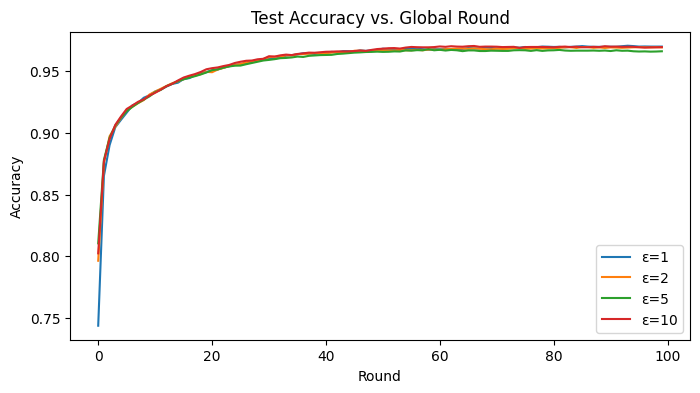

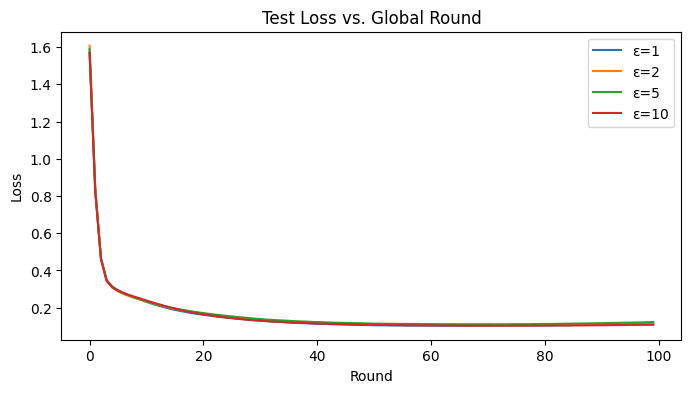

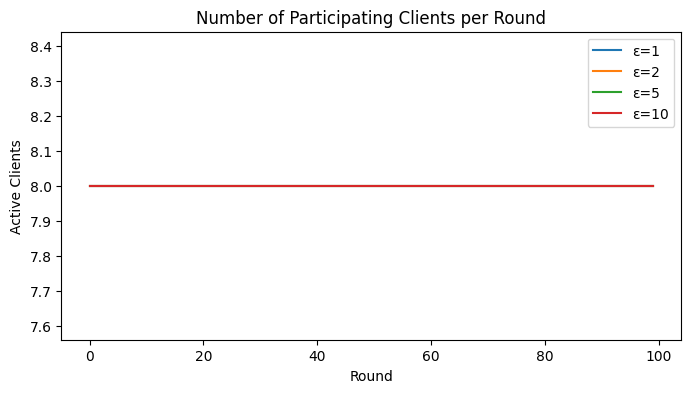

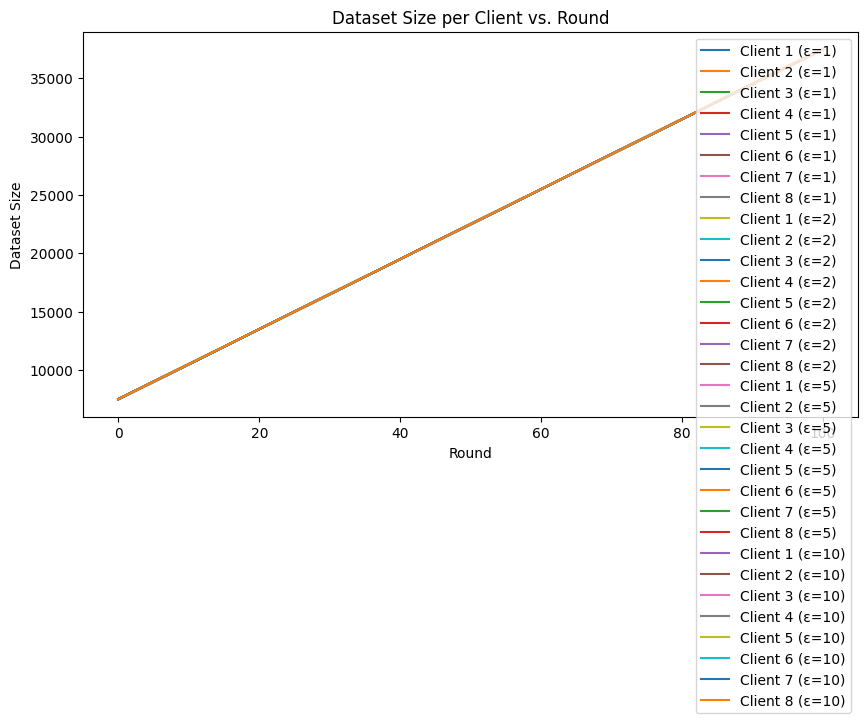

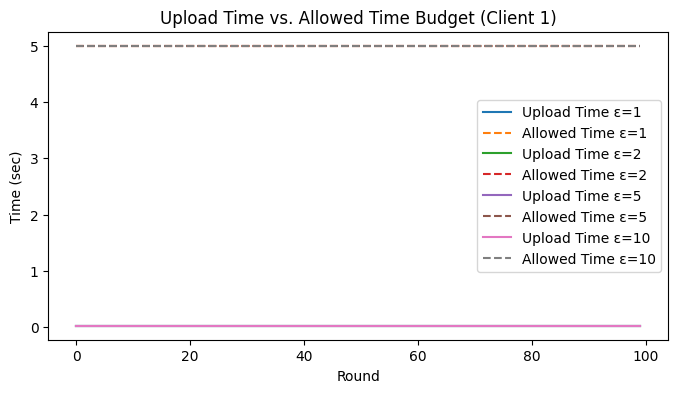

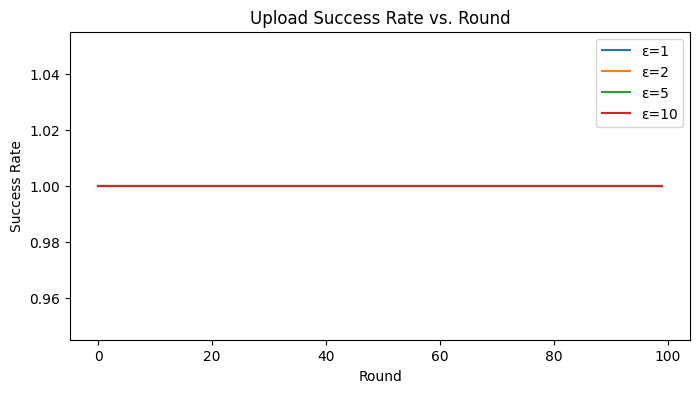

In [12]:
# 1. Test Accuracy vs. Global Round
plt.figure(figsize=(8,4))
for eps in eps_list:
    plt.plot(results[eps][1], label=f"ε={eps}")
plt.title("Test Accuracy vs. Global Round")
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# 2. Test Loss vs. Global Round
plt.figure(figsize=(8,4))
for eps in eps_list:
    plt.plot(results[eps][0], label=f"ε={eps}")
plt.title("Test Loss vs. Global Round")
plt.xlabel("Round")
plt.ylabel("Loss")
plt.legend()
plt.show()

# 3. Number of Participating Clients per Round
plt.figure(figsize=(8,4))
for eps in eps_list:
    plt.plot(num_active_per_round[eps], label=f"ε={eps}")
plt.title("Number of Participating Clients per Round")
plt.xlabel("Round")
plt.ylabel("Active Clients")
plt.legend()
plt.show()

# 4. Dataset Size per Client vs. Round
plt.figure(figsize=(10,5))
for eps in eps_list:
    for m in range(M):
        plt.plot(dataset_sizes[eps][m], label=f"Client {m+1} (ε={eps})")
plt.title("Dataset Size per Client vs. Round")
plt.xlabel("Round")
plt.ylabel("Dataset Size")
plt.legend()
plt.show()

# 5. Upload Time vs. Allowed Time Budget (for client 0)
plt.figure(figsize=(8,4))
for eps in eps_list:
    plt.plot(upload_times[eps][0], label=f"Upload Time ε={eps}")
    plt.plot(allowed_times[eps][0], '--', label=f"Allowed Time ε={eps}")
plt.title("Upload Time vs. Allowed Time Budget (Client 1)")
plt.xlabel("Round")
plt.ylabel("Time (sec)")
plt.legend()
plt.show()

# 6. Upload Success Rate vs. Round
plt.figure(figsize=(8,4))
for eps in eps_list:
    plt.plot(upload_success_rate[eps], label=f"ε={eps}")
plt.title("Upload Success Rate vs. Round")
plt.xlabel("Round")
plt.ylabel("Success Rate")
plt.legend()
plt.show()

### Accuracy vs. Modulation Scheme
Compare the final test accuracy for different allowed modulation schemes (`rs`).

In [ ]:
# Accuracy vs. Modulation Scheme
mod_schemes = {
    "QPSK": [2],
    "16QAM": [4],
    "64QAM": [6],
    "QPSK+16QAM": [2,4],
    "All": [2,4,6]
}
mod_acc = {}

for name, rs_mod in mod_schemes.items():
    # Set up experiment for this modulation scheme
    rs = rs_mod
    eps = 2  # Repeat only for one privacy level for clarity
    global_model = SimpleMLP().to(device)
    global_state = global_model.state_dict()
    # Re-initialize per-client seen indices and dataset sizes
    client_seen = [set() for _ in range(M)]
    idx = torch.randperm(len(full_train_ds))
    split = len(full_train_ds) // M
    dataset_sizes_mod = [[] for _ in range(M)]
    upload_times_mod = [[] for _ in range(M)]
    allowed_times_mod = [[] for _ in range(M)]
    for m in range(M):
        client_seen[m].update(idx[m*split:(m+1)*split].tolist())
        dataset_sizes_mod[m].append(len(client_seen[m]))
    for rnd in range(1, G+1):
        dp_states, active, client_seen = run_one_round(
            global_state, global_model, client_seen, eps, rs, rnd, dataset_sizes_mod, upload_times_mod, allowed_times_mod
        )
        if dp_states:
            agg = server_aggregate(dp_states)
            global_state = agg
            global_model.load_state_dict(global_state)
    # Evaluate at the end
    _, acc = evaluate(global_model, test_loader)
    mod_acc[name] = acc

plt.figure(figsize=(7,4))
plt.bar(list(mod_acc.keys()), list(mod_acc.values()))
plt.title("Final Test Accuracy vs. Modulation Scheme (ε=2)")
plt.ylabel("Accuracy")
plt.xlabel("Modulation Scheme")
plt.ylim(0,1)
plt.show()